## Project 2: Finite element method

### Imports

In [3]:
from Problem1.Poisson import *
from Optimal_Control import *

### Problem 1: Poisson Equation

Below is the implementation of the FEM solver. The test function we used is $u = e^x(1-x)^2x$. The implementation can generate a uniform and squared mesh as well as take in custom partitions of the domain. We get a convergence of approximatly $O(h^2)$ in the $H^1$ norm, and $O(h^3)$ in the $L_2$ norm.

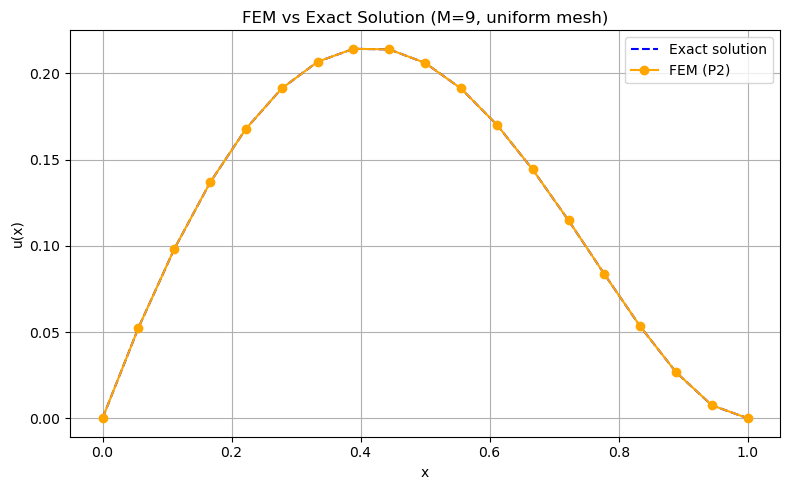

         h Error in L2 and H1 norm
[0.12851848 0.03780449 0.00989474 0.00250318 0.00062767 0.00015703]
[6.18024136e-03 8.82078985e-04 1.14680261e-04 1.44849089e-05
 1.81540015e-06 2.27075426e-07]


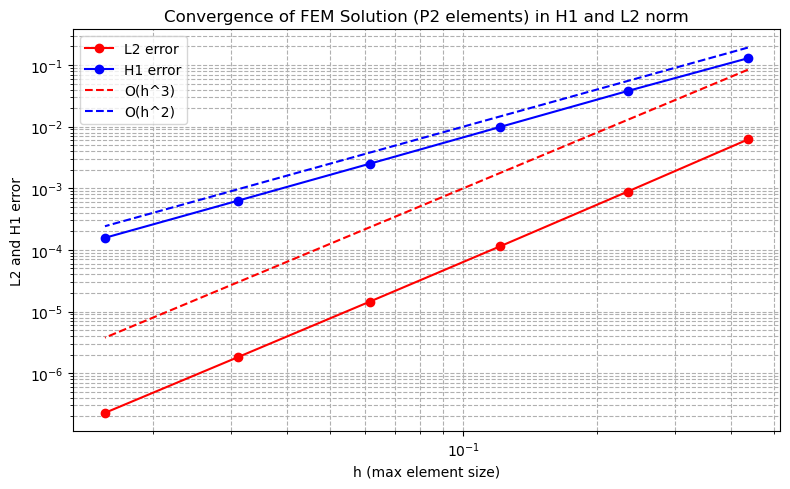


Estimated convergence rates:
M = 4 --> 8: rate_H1 = 1.96, rate_L2 = 3.12
M = 8 --> 16: rate_H1 = 2.03, rate_L2 = 3.09
M = 16 --> 32: rate_H1 = 2.03, rate_L2 = 3.06
M = 32 --> 64: rate_H1 = 2.02, rate_L2 = 3.03
M = 64 --> 128: rate_H1 = 2.01, rate_L2 = 3.02


In [5]:

# ------------------Example usage ---------------------------

exact = lambda x: (np.exp(x) * (1 - x)**2)*x
f = lambda x: -(np.exp(x)*x**3 + 4*x**2*np.exp(x) - np.exp(x)*x-2*np.exp(x))

#  Custom Mesh
custom_mesh = [0.0, 0.1, 0.3, 0.7, 1.0]
M_custom = len(custom_mesh) - 1  # number of elements = len - 1

# Uniform mesh
M = 9

u, x_dofs, _ = compute_solution(f, M, method="uniform")
plot_solution(u, x_dofs, exact, M, method="uniform")

# Convergence test with standard methods
Ms = [4, 8, 16, 32, 64, 128]
plot_convergence(f, exact, Ms, method="squared")


## Problem 2: Optimal Control
This script solves a 1D optimal control problem: 

$$
\min_{u_h,\, y_h \in V_h} \; \frac{1}{2} \| y_h - \bar{y}_d \|_{L^2(\Omega)}^2 + \frac{\alpha}{2} \| u_h \|_{L^2(\Omega)}^2
$$
subject to
$$
a(y_h, v) = \langle u_h, v \rangle_{L^2(\Omega)} \quad \text{for all } v \in V_h.
\tag{6}
$$
 
 The state and control are discretized with continuous P2 elements, and the optimality system is derived and solved in matrix form. The global stiffness and mass matrices are assembled element-wise using exact analytical expressions, and Dirichlet boundary conditions are enforced by reducing the system.

H1 error: 1.8878e+00


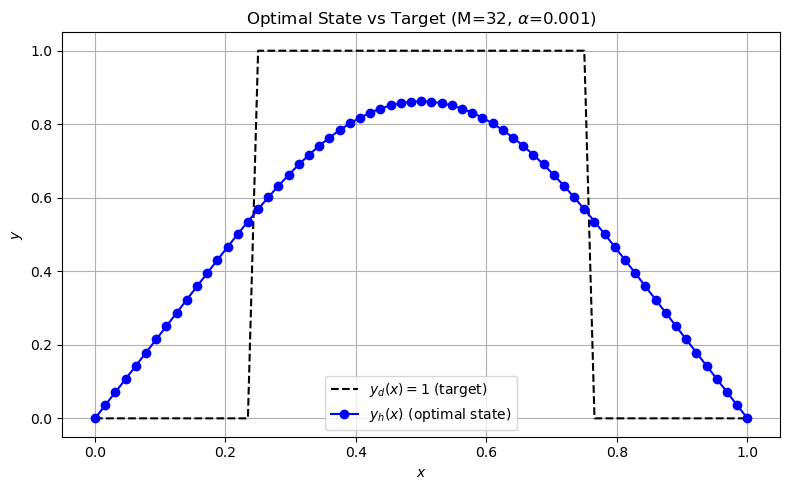

In [7]:
# -------------------- MAIN SCRIPT -------------------
# Setup y_d = 1
M = 32
nodes = np.linspace(0, 1, M + 1)
alpha = 1e-3
y_d_func = lambda x: np.where((0.25 <= x) & (x <= 0.75), 1.0, 0.0)
y_d_prime = lambda x: 0.0  

# Assemble and interpolate
B, F, N_dof = assemble_global_matrices(nodes)
y_d_vector = interpolate_y_d(y_d_func, nodes)
y, u = solve_optimal_control_sparse(B, F, y_d_vector, alpha)

# Add BCs to solution
y_full = np.zeros(N_dof)
y_full[1:-1] = y

# Global P2 mesh points
x_global = np.zeros(N_dof)
for k in range(M):
    a = nodes[k]
    b = nodes[k + 1]
    x0, x1, x2 = a, (a + b) / 2, b
    dofs = local_to_global_dof_index(k)
    x_global[dofs[0]] = x0
    x_global[dofs[1]] = x1
    x_global[dofs[2]] = x2

# Compute error
error = compute_H1_error(y_full, x_global, y_d_func, y_d_prime)
print(f"H1 error: {error:.4e}")

# Plot
sorted_indices = np.argsort(x_global)
x_sorted = x_global[sorted_indices]
y_sorted = y_full[sorted_indices]
y_d_exact = y_d_func(x_sorted)

plt.figure(figsize=(8, 5))
plt.plot(x_sorted, y_d_exact * np.ones_like(x_sorted), 'k--', label='$y_d(x) = 1$ (target)')
plt.plot(x_sorted, y_sorted, 'b-', marker='o', label='$y_h(x)$ (optimal state)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Optimal State vs Target (M={M}, $\\alpha$={alpha})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
